In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from matplotlib import animation
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = (6,6)

### Function to build a burger (cylinder) with radius 'r', height 'z', and resolution 'res'

In [2]:
def build_burger(r,z,res):
    Φ = np.linspace(0,2*np.pi,res)
    Z = np.empty((res,res))      
    
    ih=0
    for ix in range(0,res):
        for iy in range(0,res):
            Z[ix,iy] = ih
        ih += z/res
            
    x = radius*np.cos(Φ)
    y = radius*np.sin(Φ)

    X = np.array([x for n in range(0,res)])
    Y = np.array([y for n in range(0,res)])
    
    return X,Y,Z

# The following equations are used in this code:

### Rotation matrix in x:
$$
R_{x} = \left(\begin{array}{ccccc}
x \\
y\cos(\theta) - z\sin(\theta) \\
y\sin(\theta) + z\cos(\theta) \\
\end{array}\right)
$$

### Position of CM:
$$
z = -\frac{1}{2}gt^2 + \sqrt{2gh}t
$$

### Initial angular velocity:
$$
\omega_0 = \frac{(2n+1)I_{xx}\pi}{4mR}\sqrt{\frac{g}{2h}}
$$

$$
n = 0,1,2,...
$$

### Moment of inertia around $\hat{x}$:
$$
I_{xx} = \frac{1}{12}m(3R^2 + H^2)
$$

### Angular momentum:
$$
L = 2mR\omega_0
$$

### Angle as a function of time:
$$
\theta(t) = \frac{2mR\omega_0}{I_{xx}}t
$$

### Condition for edges to not hit flipper:
$$
\frac{h}{2n+1} > \frac{1}{4}\pi R
$$

So the two values we need to feed our program (besides the height, radius and mass of the burger) is $h$ and $n$

In [9]:
radius     = 4
height     = 3
mass       = 0.3
Iₓₓ        = 1/12*mass*(3*radius**2 + height**2)
n          = 1
g          = 9.81
max_height = 1/4 * np.pi * radius * (2*n + 1)
ω0         = (2*n+1)*Iₓₓ*np.pi/4.0/mass/radius*np.sqrt(g/2.0/max_height)
L          = 2.0*mass*radius*ω0

if (max_height/(2*n+1) < 1/4.0*np.pi*radius):
    print(f"WARNING: RATIO OF h/(2n+1) to πR/4 IS INVALID")
    print(f"max_height/(2*n+1) = {max_height/(2*n+1)} < 1/4.0*np.pi*radius = {1/4.0*np.pi*radius}")

# Rotation matrices
def Rx(x,y,z,θ):
    x̂ = x
    ŷ = y*np.cos(θ) - z*np.sin(θ)
    ẑ = y*np.sin(θ) + z*np.cos(θ)
    #if (x̂ < 0 or ŷ < 0 or ẑ < 0):
    #    return np.array([0,0,0])
    return np.array([x̂, ŷ, ẑ])

# Angle as a function of time
def Δθ(t,h=max_height,R=radius,m=mass,g=g,I=Iₓₓ):
    return 2*m*R*ω0*t/I

# Vertical position of CM (takes matrix as a parameter)
def ΔZ(t,g=g,h=max_height):
    T = np.empty(len(t))
    for it in range(0,len(t)):
        T[it] = np.max(0,-0.5*g*t[it]**2 + np.sqrt(2*g*h)*t[it])
    return T

# Vertical position of CM (takes number as a parameter)
def Δz(t,g=g,h=max_height):
    return max(0,-0.5*g*t**2 + np.sqrt(2*g*h)*t)

(-6.0, 6.0)

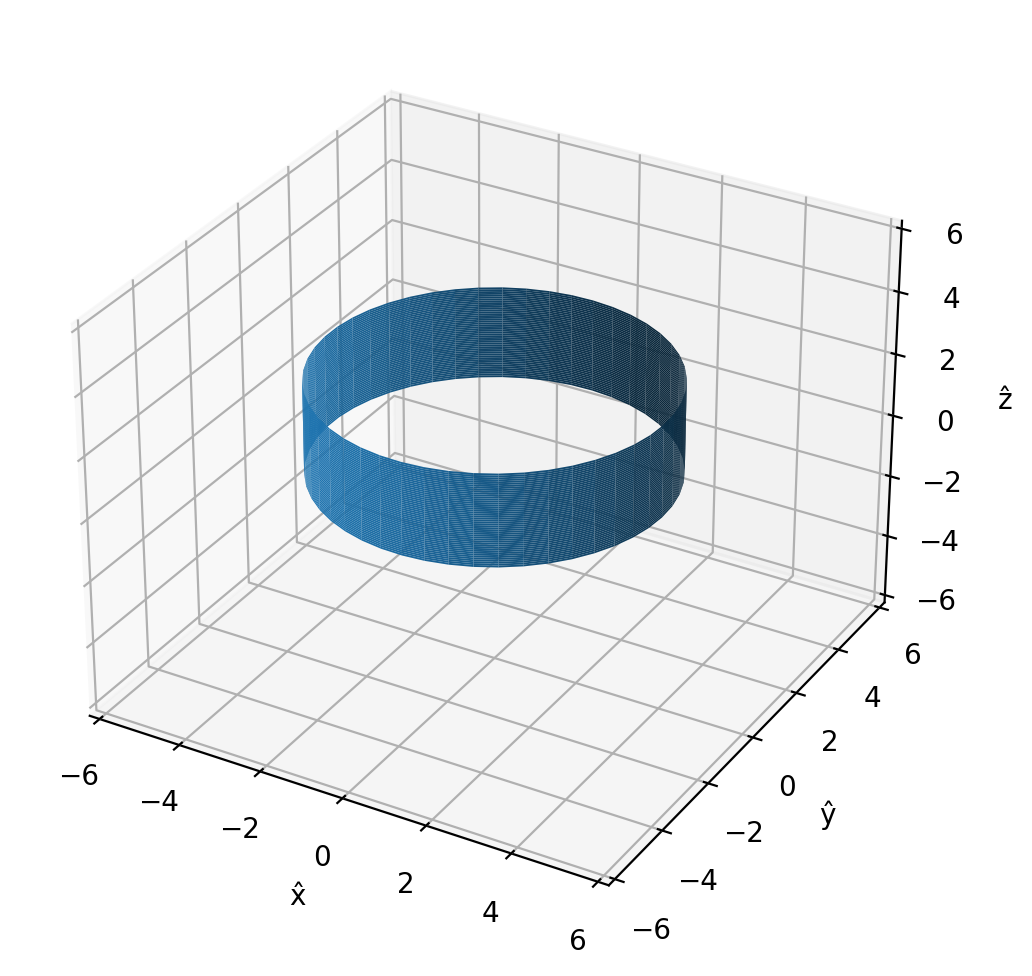

In [10]:
# Building our burger

res = 50

X,Y,Z = build_burger(radius,height,res)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot_surface(X[:],Y[:],Z[:])
ax.set_xlabel("x̂")
ax.set_ylabel("ŷ")
ax.set_zlabel("ẑ")
lim = max(radius,height)*1.5
ax.axes.set_xlim(-lim,lim)
ax.axes.set_ylim(-lim,lim)
ax.axes.set_zlim(-lim,lim)

In [11]:
# tmax is one period
tmax = (2*n + 1)*Iₓₓ/2.0/mass/radius/ω0
δt   = 0.01
Nt   = int(tmax/δt)

# Side view of burger rotating
@widgets.interact(t=(0.0,tmax,tmax/Nt))
def disp(t=0):
    it = int((t/tmax)*(Nt-1))*0.05
    if (Δz(it) != 0):
        Xc,Yc,Zc = Rx(X,Y,Z,Δθ(it))
    else:
        Xc,Yc,Zc = Rx(X,Y,Z,0)
    plt.scatter(Yc[:],Zc[:] + Δz(it))
    plt.xlabel("ŷ")
    plt.ylabel("ẑ")
    lim = max(radius,max_height)
    plt.xlim(-lim,lim)
    plt.ylim(-lim,lim)
    
    
# NOTE:
# This was done because once we start the simulations in 3D, if I label the graphs properly the cylinder actually seems to rotate around ŷ
# This here is shown to verify that our cylinder does indeed rotate about x̂, so it justifies me switching the x̂ labels and ŷ labels in the future

interactive(children=(FloatSlider(value=0.0, description='t', max=0.8824623406767212, step=0.01002798114405365…

In [12]:
# Putting components at each time into an array, for animation

Xt = np.empty(Nt,dtype='object')
Yt = np.empty(Nt,dtype='object')
Zt = np.empty(Nt,dtype='object')

it = 0
for itn in range(0,Nt):
    it2 = int((it/tmax)*(Nt-1))*0.05
    if (Δz(it2) != 0):
        Xt[itn] = Rx(X,Y,Z,Δθ(it2))[0]
        Yt[itn] = Rx(X,Y,Z,Δθ(it2))[1]
        Zt[itn] = Rx(X,Y,Z,Δθ(it2))[2] + Δz(it2)
    else:
        Xt[itn] = Rx(X,Y,Z,0)[0]
        Yt[itn] = Rx(X,Y,Z,0)[1]
        Zt[itn] = Rx(X,Y,Z,0)[2]
    it+=tmax/Nt

In [13]:
# An interactive slider for fun. You can switch between scatter and plot_surface as you like

tmax = (2*n+1)*np.pi*Iₓₓ/2.0/mass/radius/ω0
δt   = 0.01
Nt   = int(tmax/δt)

Tt = np.linspace(0,tmax,res**2)

@widgets.interact(t=(0.0,tmax,tmax/Nt))
def disp(t=0):
    it = int((t/tmax)*(Nt-1))
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.scatter(Xt[it][:],Yt[it][:],Zt[it][:],c=Tt)
    #ax.plot_surface(Xt[it][:],Yt[it][:],Zt[it][:])
    ax.set_xlabel("x̂")
    ax.set_ylabel("ŷ")
    ax.set_zlabel("ẑ")
    lim = max(radius,max_height)
    ax.axes.set_xlim(-lim,lim)
    ax.axes.set_ylim(-lim,lim)
    ax.axes.set_zlim(0,lim)

interactive(children=(FloatSlider(value=0.0, description='t', max=2.772337206539641, step=0.010008437568735167…

In [18]:
'''
# Creating the animation

fig = plt.figure(facecolor='white')
ax = plt.axes(projection = "3d")

lim = max(radius,max_height)
ax.set_xlim(-lim,lim)
ax.set_ylim(-lim,lim)
ax.set_zlim(0,lim)
ax.set_xlabel("ŷ")
ax.set_ylabel("x̂")
ax.set_zlabel("ẑ")

x0 = Xt[0]
y0 = Yt[0]
z0 = Zt[0]

surface_color = "tab:brown"

def init():
    ax.plot_surface(x0, y0, z0, color=surface_color)
    return fig,

def animate(i):
    # remove previous data
    ax.collections.clear()
    # add the burger at time 'i'
    ax.plot_surface(Xt[i],Yt[i],Zt[i], color=surface_color)
    return fig,

ani = animation.FuncAnimation(fig, animate, init_func = init, frames = int(tmax*25), interval = 25)

plt.show()

ani.save(f"n={n},ω0={ω0}.gif",writer="imagemagick")
'''

'\n# Creating the animation\n\nfig = plt.figure(facecolor=\'white\')\nax = plt.axes(projection = "3d")\n\nlim = max(radius,max_height)\nax.set_xlim(-lim,lim)\nax.set_ylim(-lim,lim)\nax.set_zlim(0,lim)\nax.set_xlabel("ŷ")\nax.set_ylabel("x̂")\nax.set_zlabel("ẑ")\n\nx0 = Xt[0]\ny0 = Yt[0]\nz0 = Zt[0]\n\nsurface_color = "tab:brown"\n\ndef init():\n    ax.plot_surface(x0, y0, z0, color=surface_color)\n    return fig,\n\ndef animate(i):\n    # remove previous data\n    ax.collections.clear()\n    # add the burger at time \'i\'\n    ax.plot_surface(Xt[i],Yt[i],Zt[i], color=surface_color)\n    return fig,\n\nani = animation.FuncAnimation(fig, animate, init_func = init, frames = int(tmax*25), interval = 25)\n\nplt.show()\n\nani.save(f"n={n},ω0={ω0}.gif",writer="imagemagick")\n'